In [32]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
import math


from dash import Dash, html, dcc
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=False)

from typing import *

app = Dash(__name__)

PLOTLY_THEME = "plotly_white"
EXPORT_DIR = "image_out"
MAIN_DATA = "data.csv"

import os

if not os.path.exists(EXPORT_DIR):
    os.mkdir(EXPORT_DIR)

# Load Datasets

In [33]:
if not os.path.exists(MAIN_DATA):
    # Auto download from pre-computed Nextcloud server
    import requests
    r = requests.get("https://next.jmw.nz/s/L7drTr5wLqs67Te/download")
    with open(MAIN_DATA, "wb") as f:
        f.write(r.content)

In [34]:
power_sources = pd.read_csv("power_sources.csv", header=None)
power_sources.columns = ["source_id","source","ci-co2-per-kwh"]
power_sources

source_id      source  ci-co2-per-kwh
0          1     battery               8
1          2      co_gen             249
2          3         gas             410
3          4        coal            1073
4          5       hydro               8
5          6  geothermal              90
6          8        wind               7
7          7      diesel             850

In [35]:
data_raw = pd.read_csv("data.csv", index_col=0)

# Convert reading_timestamp to datetime
data_raw["reading_timestamp"] = pd.to_datetime(data_raw["reading_timestamp"])

data_raw.loc[data_raw["source_id"]==5].tail(16)

source_id  generation  capacity         reading_timestamp
id                                                              
81676          5        3182      5415 2023-04-20 19:00:00+00:00
81684          5        3493      5415 2023-04-20 19:30:00+00:00
81692          5        3695      5415 2023-04-20 20:00:00+00:00
81700          5        3785      5415 2023-04-20 20:30:00+00:00
81708          5        3837      5415 2023-04-20 21:00:00+00:00
81716          5        3803      5415 2023-04-20 21:30:00+00:00
81724          5        3747      5415 2023-04-20 22:00:00+00:00
81732          5        3736      5415 2023-04-20 22:30:00+00:00
81740          5        3724      5415 2023-04-20 23:00:00+00:00
81748          5        3681      5415 2023-04-20 23:30:00+00:00
81756          5        3701      5415 2023-04-21 00:00:00+00:00
81764          5        3682      5415 2023-04-21 00:30:00+00:00
81772          5        3663      5415 2023-04-21 01:00:00+00:00
81780          5        3631      5415 2023-04-21 01:30:00+00:00
81788          5        3624      5415 2023-04-21 02:00:00+00:00
51575          5        3554      5415 2023-01-19 05:00:00+00:00

In [36]:
data_raw = data_raw.merge(power_sources)
data_raw

source_id  generation  capacity         reading_timestamp   source  \
0              1           0         1 2022-08-20 02:30:00+00:00  battery   
1              1           0         1 2022-08-20 03:00:00+00:00  battery   
2              1           0         1 2022-08-20 03:30:00+00:00  battery   
3              1           0         1 2022-08-20 04:00:00+00:00  battery   
4              1           0         1 2022-08-20 04:30:00+00:00  battery   
...          ...         ...       ...                       ...      ...   
81627          8          52      1040 2023-04-21 00:30:00+00:00     wind   
81628          8          60      1040 2023-04-21 01:00:00+00:00     wind   
81629          8          57      1040 2023-04-21 01:30:00+00:00     wind   
81630          8          48      1040 2023-04-21 02:00:00+00:00     wind   
81631          8         102      1040 2023-01-19 05:00:00+00:00     wind   

       ci-co2-per-kwh  
0                   8  
1                   8  
2                   8  
3                   8  
4                   8  
...               ...  
81627               7  
81628               7  
81629               7  
81630               7  
81631               7  

[81632 rows x 6 columns]

In [37]:
# Flatten data structure, it now has 16 columns
# 	id	source_id	generation	capacity	reading_timestamp\
# Transform so each of the 8 source_id's are in their own column with their generation and capacity
# Group the source ID's by their reading timestamp
generation_logs = data_raw.pivot_table(index=["reading_timestamp"], columns="source", values=["generation","ci-co2-per-kwh"]).reset_index()
generation_logs

reading_timestamp ci-co2-per-kwh                           \
source                                  battery co_gen  coal diesel  gas   
0      2022-08-20 02:00:00+00:00              8    249  1073    850  410   
1      2022-08-20 02:30:00+00:00              8    249  1073    850  410   
2      2022-08-20 03:00:00+00:00              8    249  1073    850  410   
3      2022-08-20 03:30:00+00:00              8    249  1073    850  410   
4      2022-08-20 04:00:00+00:00              8    249  1073    850  410   
...                          ...            ...    ...   ...    ...  ...   
10199  2023-04-21 00:00:00+00:00              8    249  1073    850  410   
10200  2023-04-21 00:30:00+00:00              8    249  1073    850  410   
10201  2023-04-21 01:00:00+00:00              8    249  1073    850  410   
10202  2023-04-21 01:30:00+00:00              8    249  1073    850  410   
10203  2023-04-21 02:00:00+00:00              8    249  1073    850  410   

                             generation                                     \
source geothermal hydro wind    battery co_gen coal diesel  gas geothermal   
0              90     8    7          0    109    0      0  201        923   
1              90     8    7          0     99    0      0  202        924   
2              90     8    7          0     87    0      0  221        923   
3              90     8    7          0     86    0      0  221        924   
4              90     8    7          0    101    0      0  251        924   
...           ...   ...  ...        ...    ...  ...    ...  ...        ...   
10199          90     8    7          0     95  178      0  434        782   
10200          90     8    7          0     93  178      0  432        784   
10201          90     8    7          0     94  164      0  432        783   
10202          90     8    7          0     96  160      0  427        783   
10203          90     8    7          0     94  158      0  431        785   

                   
source hydro wind  
0       2783  616  
1       2829  567  
2       2899  531  
3       2926  537  
4       2942  536  
...      ...  ...  
10199   3701   58  
10200   3682   52  
10201   3663   60  
10202   3631   57  
10203   3624   48  

[10204 rows x 17 columns]

# Scan for issues in Dataset

In [38]:
# Check for partial rows
generation_logs[generation_logs.isnull().any(axis=1)]


Empty DataFrame
Columns: [(reading_timestamp, ), (ci-co2-per-kwh, battery), (ci-co2-per-kwh, co_gen), (ci-co2-per-kwh, coal), (ci-co2-per-kwh, diesel), (ci-co2-per-kwh, gas), (ci-co2-per-kwh, geothermal), (ci-co2-per-kwh, hydro), (ci-co2-per-kwh, wind), (generation, battery), (generation, co_gen), (generation, coal), (generation, diesel), (generation, gas), (generation, geothermal), (generation, hydro), (generation, wind)]
Index: []

In [39]:
# Look for gaps in timeseries data where the data-collector was offline
# 1. Find the difference between each timestamp



last_timestamp = generation_logs["reading_timestamp"].iloc[0]

delta_errors_basic = pd.DataFrame(columns=["delta_time","time_of_day"])

def timeToNumeric(time: datetime.time) -> float:
    return time.hour + time.minute / 60

for timestamp in generation_logs["reading_timestamp"]:
    delta_time = timestamp - last_timestamp
    # 2. If the difference is greater than 15 minutes, then there is a gap
    if delta_time > pd.Timedelta(minutes=30):
        delta_errors_basic.loc[len(delta_errors_basic)] = [delta_time, timeToNumeric(timestamp.time())]
    last_timestamp = timestamp
delta_errors_basic

delta_time  time_of_day
0   0 days 01:30:00         17.0
1   2 days 13:00:00         10.5
2   3 days 19:30:00          2.5
3   0 days 01:00:00         20.0
4   2 days 03:30:00         23.5
..              ...          ...
148 0 days 03:30:00         15.5
149 0 days 01:00:00          8.0
150 0 days 02:30:00         14.5
151 0 days 04:00:00         16.0
152 0 days 03:30:00         15.5

[153 rows x 2 columns]

In [40]:
for index,err in delta_errors_basic.iterrows():
    if err["delta_time"].total_seconds() / 60**2 <= 0:
        print(err,index)

In [41]:
time_day_freq = delta_errors_basic["time_of_day"].value_counts().sort_index().rename_axis('unique_values').reset_index(name='counts')

In [42]:
# Set the desired time interval
import datetime

# Create a new DataFrame with the desired time slots

time_slots = list(map(lambda x:x/2,range(0,48)))

# Create a DataFrame with the time slots
time_df = pd.DataFrame({'unique_values': time_slots})

# Merge the existing DataFrame with the time slots DataFrame
time_day_freq = pd.merge(time_df, time_day_freq, on='unique_values', how='left')
# time_day_freq = pd.concat([time_df.set_index('unique_values'), time_day_freq.set_index('unique_values')], axis=1, join='outer')


# # Fill NaN values with 0
time_day_freq['counts'] = time_day_freq['counts'].fillna(0)

time_day_freq['unique_values'] = time_day_freq.apply(lambda x: datetime.time(hour = math.floor(x['unique_values']), minute= int((x['unique_values']%1)*60)), axis=1)

In [43]:

fig = px.line(time_day_freq, y="counts", x="unique_values", title="Start times for gaps in data collection")
fig.show()

In [44]:
# fig = px.violin(errors,labels={
#     "value": "Delta between readings during outage",
#     "variable": "Source"
# }, points='all', title="Gaps in data collection", orientation="h")
# fig.show()

COLLECTION_GAP_HEALING_THRESHOLD = pd.Timedelta(hours=5)

fig = go.Figure()
fig.add_trace(go.Violin(x=list(map(lambda x: x[1]["delta_time"].total_seconds() / 60**2,delta_errors_basic.iterrows())), name=""))
fig.add_vline(x=5, line_dash="dot",
              annotation_text="small-big gap healing threshold", 
              annotation_position="top right",)

fig.update_traces(orientation='h', side='positive', width=3, points='all')
fig.update_layout(xaxis_dtick=COLLECTION_GAP_HEALING_THRESHOLD.seconds / 60**2)

fig.update_layout(title="Gaps in data collection", xaxis_title="Hours between readings")

fig.show()

In [45]:
# Find Small gaps and heal them
generation_logs_insert = pd.DataFrame(columns=generation_logs.columns)

last_timestamp = generation_logs["reading_timestamp"].iloc[0]
for index,row in generation_logs.iterrows():
    current_timestamp = row[("reading_timestamp","")]
    time_delta = current_timestamp - last_timestamp
    if time_delta > pd.Timedelta(minutes=30) and time_delta < COLLECTION_GAP_HEALING_THRESHOLD:
        # Get the last row
        last_row = generation_logs.iloc[index-1]
        # Get missing timestamps with interval of 30 minutes
        missing_timestamps = pd.date_range(last_timestamp, current_timestamp, freq="30min")[1:-1]
        # Generate new rows with the missing timestamps
        for i in missing_timestamps:
            # Data will be interpolated later
            generation_logs_insert.loc[len(generation_logs_insert)] = {("reading_timestamp",""):i}

    last_timestamp = current_timestamp

# Now insert new logs into the main DataFrame
generation_logs = generation_logs.append(generation_logs_insert).sort_values(by=("reading_timestamp",""))

generation_logs_insert

/tmp/ipykernel_303450/3201958161.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



reading_timestamp ci-co2-per-kwh                         \
source                                  battery co_gen coal diesel gas   
0      2022-08-20 16:00:00+00:00            NaN    NaN  NaN    NaN NaN   
1      2022-08-20 16:30:00+00:00            NaN    NaN  NaN    NaN NaN   
2      2022-10-19 19:30:00+00:00            NaN    NaN  NaN    NaN NaN   
3      2022-10-25 11:30:00+00:00            NaN    NaN  NaN    NaN NaN   
4      2022-10-29 11:30:00+00:00            NaN    NaN  NaN    NaN NaN   
..                           ...            ...    ...  ...    ...  ..   
384    2023-04-20 13:00:00+00:00            NaN    NaN  NaN    NaN NaN   
385    2023-04-20 13:30:00+00:00            NaN    NaN  NaN    NaN NaN   
386    2023-04-20 14:00:00+00:00            NaN    NaN  NaN    NaN NaN   
387    2023-04-20 14:30:00+00:00            NaN    NaN  NaN    NaN NaN   
388    2023-04-20 15:00:00+00:00            NaN    NaN  NaN    NaN NaN   

                             generation                                    \
source geothermal hydro wind    battery co_gen coal diesel gas geothermal   
0             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
1             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
2             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
3             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
4             NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
..            ...   ...  ...        ...    ...  ...    ...  ..        ...   
384           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
385           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
386           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
387           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   
388           NaN   NaN  NaN        NaN    NaN  NaN    NaN NaN        NaN   

                   
source hydro wind  
0        NaN  NaN  
1        NaN  NaN  
2        NaN  NaN  
3        NaN  NaN  
4        NaN  NaN  
..       ...  ...  
384      NaN  NaN  
385      NaN  NaN  
386      NaN  NaN  
387      NaN  NaN  
388      NaN  NaN  

[389 rows x 17 columns]

In [46]:
for area in ("generation","ci-co2-per-kwh"):
    generation_logs[area] = generation_logs[area].interpolate(method='linear', axis=0)
generation_logs.head(32).tail(10)

reading_timestamp ci-co2-per-kwh                               \
source                                  battery co_gen    coal diesel    gas   
22     2022-08-20 13:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
23     2022-08-20 13:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
24     2022-08-20 14:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
25     2022-08-20 14:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
26     2022-08-20 15:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
27     2022-08-20 15:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
0      2022-08-20 16:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
1      2022-08-20 16:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   
28     2022-08-20 17:00:00+00:00            8.0  249.0  1073.0  850.0  410.0   
29     2022-08-20 17:30:00+00:00            8.0  249.0  1073.0  850.0  410.0   

                             generation                                      \
source geothermal hydro wind    battery co_gen coal diesel  gas  geothermal   
22           90.0   8.0  7.0        0.0  119.0  0.0    0.0  0.0  933.000000   
23           90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  934.000000   
24           90.0   8.0  7.0        0.0  115.0  0.0    0.0  0.0  936.000000   
25           90.0   8.0  7.0        0.0  114.0  0.0    0.0  0.0  936.000000   
26           90.0   8.0  7.0        0.0  119.0  0.0    0.0  0.0  936.000000   
27           90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  936.000000   
0            90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  936.666667   
1            90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  937.333333   
28           90.0   8.0  7.0        0.0  118.0  0.0    0.0  0.0  938.000000   
29           90.0   8.0  7.0        0.0  118.0  0.0    0.0  5.0  939.000000   

                            
source        hydro   wind  
22      2198.000000  379.0  
23      2127.000000  358.0  
24      2118.000000  300.0  
25      2083.000000  287.0  
26      2027.000000  308.0  
27      2032.000000  287.0  
0       2054.666667  312.0  
1       2077.333333  337.0  
28      2100.000000  362.0  
29      2137.000000  452.0

##

# Choose A Data Subset

In [47]:
SUBSET_LENGTH = 500
generation_subset = generation_logs.tail(SUBSET_LENGTH)
generation_subset
print(f"Chosen {SUBSET_LENGTH}/{len(generation_logs)} rows")

Chosen 500/10593 rows


In [48]:
SUBSET_LENGTH = 500
generation_subset = generation_logs.tail(SUBSET_LENGTH)
generation_subset
print(f"Chosen {SUBSET_LENGTH}/{len(generation_logs)} rows")

Chosen 500/10593 rows


In [49]:


fig = px.line(x=generation_subset["reading_timestamp"], y=generation_subset[("generation","hydro")], title="Hydro Generation", markers=True, range_y=[0, max(generation_subset["generation"]["hydro"])])
fig.show()

# Calculate carbon intensity
> Data from https://ecotricity.co.nz/the-truth-behind-new-zealand-s-electricity-emissions and https://www.researchgate.net/publication/235458666_Estimation_of_Carbon_Footprints_from_Diesel_Generator_Emissions


In [50]:
MW_TO_KW = 1000
GRAMS_TO_TONNE = 1/(1000*1000)
scaler = MW_TO_KW*GRAMS_TO_TONNE
co2_generation = (generation_logs["ci-co2-per-kwh"]*generation_logs["generation"])*scaler
co2_generation["reading_timestamp"] = generation_logs["reading_timestamp"]
co2_generation["cumulative_output"] = co2_generation[power_sources["source"]].sum(axis=1)
co2_generation

source  battery  co_gen     coal  diesel     gas  geothermal   hydro   wind  \
0           0.0  27.141    0.000     0.0   82.41       83.07  22.264  4.312   
1           0.0  24.651    0.000     0.0   82.82       83.16  22.632  3.969   
2           0.0  21.663    0.000     0.0   90.61       83.07  23.192  3.717   
3           0.0  21.414    0.000     0.0   90.61       83.16  23.408  3.759   
4           0.0  25.149    0.000     0.0  102.91       83.16  23.536  3.752   
...         ...     ...      ...     ...     ...         ...     ...    ...   
10199       0.0  23.655  190.994     0.0  177.94       70.38  29.608  0.406   
10200       0.0  23.157  190.994     0.0  177.12       70.56  29.456  0.364   
10201       0.0  23.406  175.972     0.0  177.12       70.47  29.304  0.420   
10202       0.0  23.904  171.680     0.0  175.07       70.47  29.048  0.399   
10203       0.0  23.406  169.534     0.0  176.71       70.65  28.992  0.336   

source         reading_timestamp  cumulative_output  
0      2022-08-20 02:00:00+00:00            219.197  
1      2022-08-20 02:30:00+00:00            217.232  
2      2022-08-20 03:00:00+00:00            222.252  
3      2022-08-20 03:30:00+00:00            222.351  
4      2022-08-20 04:00:00+00:00            238.507  
...                          ...                ...  
10199  2023-04-21 00:00:00+00:00            492.983  
10200  2023-04-21 00:30:00+00:00            491.651  
10201  2023-04-21 01:00:00+00:00            476.692  
10202  2023-04-21 01:30:00+00:00            470.571  
10203  2023-04-21 02:00:00+00:00            469.628  

[10593 rows x 10 columns]

In [51]:
co2_generation_subset = co2_generation.tail(SUBSET_LENGTH)
co2_generation_subset

source  battery  co_gen     coal  diesel     gas  geothermal   hydro   wind  \
9759        0.0  31.374    0.000     0.0   78.72       70.92  13.856  3.010   
9760        0.0  31.872    0.000     0.0   88.56       71.01  15.064  3.150   
9761        0.0  31.623    0.000     0.0   99.22       71.19  16.808  3.101   
9762        0.0  31.623    0.000     0.0  104.96       71.01  19.512  3.479   
9763        0.0  31.623    0.000     0.0  107.83       71.01  22.416  3.346   
...         ...     ...      ...     ...     ...         ...     ...    ...   
10199       0.0  23.655  190.994     0.0  177.94       70.38  29.608  0.406   
10200       0.0  23.157  190.994     0.0  177.12       70.56  29.456  0.364   
10201       0.0  23.406  175.972     0.0  177.12       70.47  29.304  0.420   
10202       0.0  23.904  171.680     0.0  175.07       70.47  29.048  0.399   
10203       0.0  23.406  169.534     0.0  176.71       70.65  28.992  0.336   

source         reading_timestamp  cumulative_output  
9759   2023-04-10 16:30:00+00:00            197.880  
9760   2023-04-10 17:00:00+00:00            209.656  
9761   2023-04-10 17:30:00+00:00            221.942  
9762   2023-04-10 18:00:00+00:00            230.584  
9763   2023-04-10 18:30:00+00:00            236.225  
...                          ...                ...  
10199  2023-04-21 00:00:00+00:00            492.983  
10200  2023-04-21 00:30:00+00:00            491.651  
10201  2023-04-21 01:00:00+00:00            476.692  
10202  2023-04-21 01:30:00+00:00            470.571  
10203  2023-04-21 02:00:00+00:00            469.628  

[500 rows x 10 columns]

In [52]:
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "scatter"}],[{"type": "heatmap"}]],
    )

In [53]:
import json
json.dumps(list(power_sources["source"]))

'["battery", "co_gen", "gas", "coal", "hydro", "geothermal", "wind", "diesel"]'

In [54]:
order = ["battery", "diesel", "wind", "geothermal", "hydro", "co_gen", "gas", "coal"]
fig = px.area(co2_generation_subset, x="reading_timestamp", y=order, title="CO2e Output per Source", markers=False,labels={
                     "value": "CO2e Output (Tonne/hr)",
                     "reading_timestamp": "Reading Date",

                 },
)
fig.update_xaxes(minor=dict(ticks="outside", showgrid=True))
fig.show()

In [55]:
fig = px.density_heatmap(x=co2_generation_subset["reading_timestamp"], y=[1]*SUBSET_LENGTH, z=co2_generation_subset["cumulative_output"],nbinsx=500, nbinsy=1, height=300, title="Cumulative CO2e Output")
fig.update_xaxes(minor=dict(ticks="outside", showgrid=True))
fig.show()


In [56]:
cum_generation = generation_logs["generation"][power_sources["source"]].sum(axis=1)
co2_intensity = pd.DataFrame()
co2_intensity["intensity"] = (co2_generation["cumulative_output"]/cum_generation)*1000
co2_intensity["reading_timestamp"] = generation_logs["reading_timestamp"]
co2_intensity

intensity         reading_timestamp
0      47.322323 2022-08-20 02:00:00+00:00
1      47.009738 2022-08-20 02:30:00+00:00
2      47.683330 2022-08-20 03:00:00+00:00
3      47.369195 2022-08-20 03:30:00+00:00
4      50.169752 2022-08-20 04:00:00+00:00
...          ...                       ...
10199  93.937309 2023-04-21 00:00:00+00:00
10200  94.167975 2023-04-21 00:30:00+00:00
10201  91.742109 2023-04-21 01:00:00+00:00
10202  91.302095 2023-04-21 01:30:00+00:00
10203  91.367315 2023-04-21 02:00:00+00:00

[10593 rows x 2 columns]

In [57]:
co2_intensity_subset = co2_intensity.tail(SUBSET_LENGTH)
co2_intensity_subset

intensity         reading_timestamp
9759   60.550796 2023-04-10 16:30:00+00:00
9760   60.489325 2023-04-10 17:00:00+00:00
9761   59.919546 2023-04-10 17:30:00+00:00
9762   56.130477 2023-04-10 18:00:00+00:00
9763   52.977125 2023-04-10 18:30:00+00:00
...          ...                       ...
10199  93.937309 2023-04-21 00:00:00+00:00
10200  94.167975 2023-04-21 00:30:00+00:00
10201  91.742109 2023-04-21 01:00:00+00:00
10202  91.302095 2023-04-21 01:30:00+00:00
10203  91.367315 2023-04-21 02:00:00+00:00

[500 rows x 2 columns]

In [58]:
fig = px.line(co2_intensity_subset, x='reading_timestamp', y="intensity")
fig.show()


# Fit Co2 Range to Light Algorithm

In [59]:
len(co2_intensity)

10593

In [60]:
from scipy import stats
BIN_COUNT = round(len(co2_intensity)/100)
co2_readings_freq = co2_intensity["intensity"].value_counts(bins = BIN_COUNT, normalize=True).sort_index().rename_axis('unique_values').reset_index(name='counts')
co2_readings_freq["avg_value"] = co2_readings_freq["unique_values"].apply(lambda x: x.mid)
co2_readings_freq

unique_values    counts  avg_value
0      (20.355, 21.579]  0.001322    20.9670
1      (21.579, 22.685]  0.002549    22.1320
2      (22.685, 23.792]  0.003587    23.2385
3      (23.792, 24.898]  0.006986    24.3450
4      (24.898, 26.004]  0.007175    25.4510
..                  ...       ...        ...
101  (132.193, 133.299]  0.000283   132.7460
102  (133.299, 134.405]  0.000094   133.8520
103  (134.405, 135.512]  0.000189   134.9585
104  (135.512, 136.618]  0.000000   136.0650
105  (136.618, 137.724]  0.000094   137.1710

[106 rows x 3 columns]

In [61]:
all = list(map(lambda x: [float(x)], range(0,int(max(co2_intensity["intensity"]))+1)))
all

[[0.0],
 [1.0],
 [2.0],
 [3.0],
 [4.0],
 [5.0],
 [6.0],
 [7.0],
 [8.0],
 [9.0],
 [10.0],
 [11.0],
 [12.0],
 [13.0],
 [14.0],
 [15.0],
 [16.0],
 [17.0],
 [18.0],
 [19.0],
 [20.0],
 [21.0],
 [22.0],
 [23.0],
 [24.0],
 [25.0],
 [26.0],
 [27.0],
 [28.0],
 [29.0],
 [30.0],
 [31.0],
 [32.0],
 [33.0],
 [34.0],
 [35.0],
 [36.0],
 [37.0],
 [38.0],
 [39.0],
 [40.0],
 [41.0],
 [42.0],
 [43.0],
 [44.0],
 [45.0],
 [46.0],
 [47.0],
 [48.0],
 [49.0],
 [50.0],
 [51.0],
 [52.0],
 [53.0],
 [54.0],
 [55.0],
 [56.0],
 [57.0],
 [58.0],
 [59.0],
 [60.0],
 [61.0],
 [62.0],
 [63.0],
 [64.0],
 [65.0],
 [66.0],
 [67.0],
 [68.0],
 [69.0],
 [70.0],
 [71.0],
 [72.0],
 [73.0],
 [74.0],
 [75.0],
 [76.0],
 [77.0],
 [78.0],
 [79.0],
 [80.0],
 [81.0],
 [82.0],
 [83.0],
 [84.0],
 [85.0],
 [86.0],
 [87.0],
 [88.0],
 [89.0],
 [90.0],
 [91.0],
 [92.0],
 [93.0],
 [94.0],
 [95.0],
 [96.0],
 [97.0],
 [98.0],
 [99.0],
 [100.0],
 [101.0],
 [102.0],
 [103.0],
 [104.0],
 [105.0],
 [106.0],
 [107.0],
 [108.0],
 [109.0],
 [110.0],


In [62]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(list(map(lambda x: [x],co2_intensity["intensity"])))
sample_scores = kde.score_samples(list(map(lambda x: [float(x)], range(0,max(co2_intensity["intensity"])))))

px.line(sample_scores, title=f"CO2e Intensity Distribution (n={len(co2_intensity)})")

TypeError: 'float' object cannot be interpreted as an integer

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

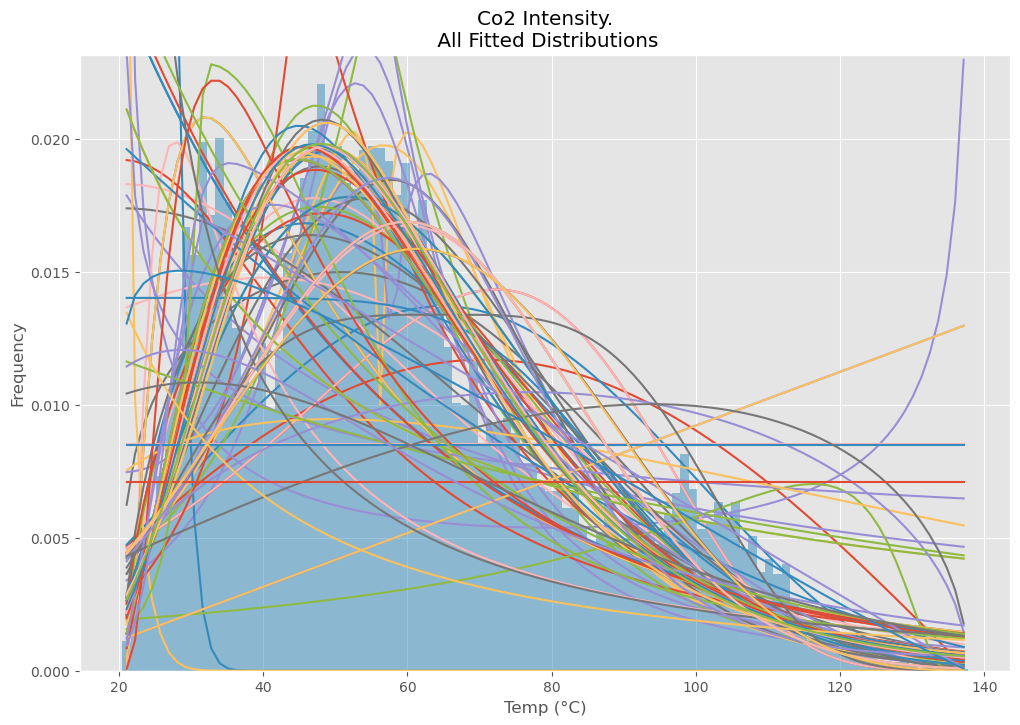

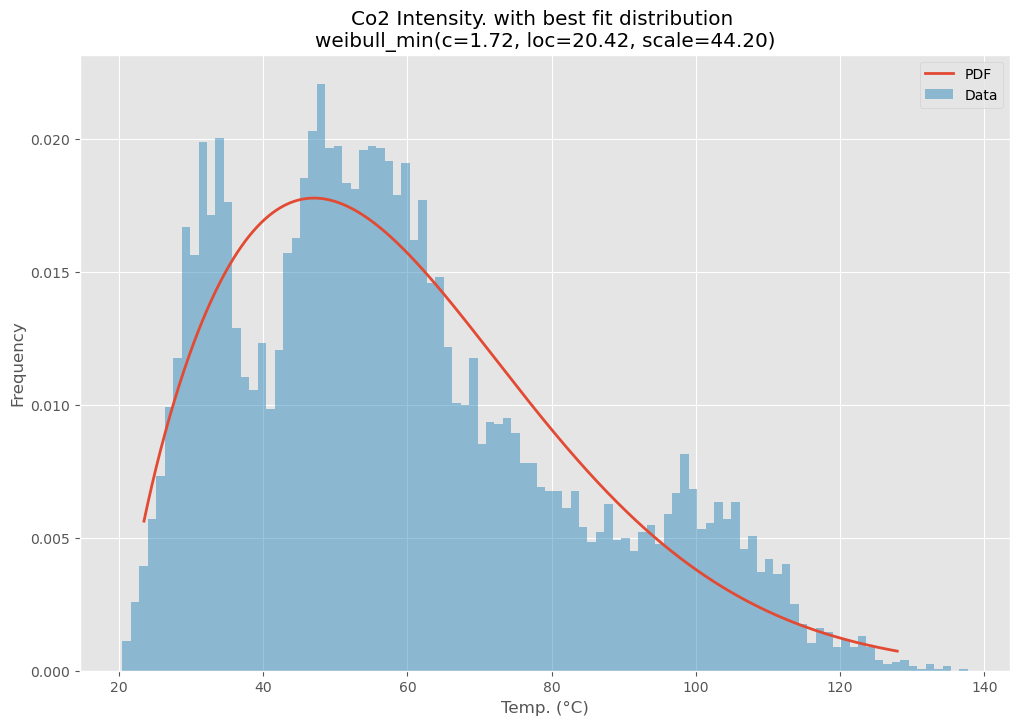

In [ ]:
# Stolen from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    def do_fit(task):
        ii, distribution = task
        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    
                except Exception:
                    return False

                # identify if this distribution is better
                return (distribution, params, sse)
        
        except Exception:
            return False


    with ThreadPoolExecutor() as executor:
        best_distributions = list(filter(lambda x: x != False,executor.map(do_fit, enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]))))


    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = co2_intensity["intensity"]

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=100, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 100, ax)


# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Co2 Intensity.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

for i in range (1):

    best_dist = best_distibutions[i]


    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=100, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax.set_title(u'Co2 Intensity. with best fit distribution \n' + dist_str)
    ax.set_xlabel(u'Temp. (°C)')
    ax.set_ylabel('Frequency')
